# TP N°2 — Minería de Datos (TUIA)
**Año:** 2025 • **Materia:** Data Mining • **Integrantes:** Fabrizio Tapia, Sebastian Palacio

**Datasets:**  
- 1000_Companies.csv (Predicción de ganancias empresariales)
- drugType.csv (Clasificación de tipo de droga farmacéutica)

**Objetivo:**  
Aplicar técnicas de aprendizaje supervisado (Árboles de Decisión, Naive Bayes y k-NN) para resolver problemas de regresión y clasificación multiclase.

---
# Parte 1: Predicción de Ganancias Empresariales (Regresión)

**Dataset:** 1000_Companies.csv  
**Objetivo:** Predecir el atributo `Profit` utilizando árboles de decisión para regresión

## 1.1 Importación de Librerías

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import metrics
from graphviz import Source


# Preparación de los datos
from feature_engine.outliers import Winsorizer # remoción de outliers
from sklearn.preprocessing import StandardScaler

# Arboles de desición
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)



# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

## 1.2 Carga y Exploración Inicial del Dataset

In [188]:
# Cargar dataset
datos_empresas = pd.read_csv('1000_Companies.csv')

# Información general
print("INFORMACIÓN GENERAL DEL DATASET \n")
print(f"Dimensiones: {datos_empresas.shape[0]} filas x {datos_empresas.shape[1]} columnas")
print(f"\nColumnas: {list(datos_empresas.columns)}")
print(f"\nTipos de datos:")
print(datos_empresas.dtypes)

INFORMACIÓN GENERAL DEL DATASET 

Dimensiones: 1000 filas x 5 columnas

Columnas: ['RyD_Spend', 'Administration', 'MarketingSpend', 'State', 'Profit']

Tipos de datos:
RyD_Spend         float64
Administration    float64
MarketingSpend    float64
State              object
Profit            float64
dtype: object


In [189]:
diccionario_variables = {
    'RyD_Spend': 'Gasto en Investigación y Desarrollo (I+D)',
    'Administration': 'Gastos Administrativos',
    'MarketingSpend': 'Gasto en Marketing',
    'State': 'Estado donde opera la empresa (New York, California, Florida)',
    'Profit': 'Ganancia de la empresa (Variable Objetivo)'
}

print("DICCIONARIO DE VARIABLES \n")

for variable, descripcion in diccionario_variables.items():
    print(f"• {variable:20s} → {descripcion}")

DICCIONARIO DE VARIABLES 

• RyD_Spend            → Gasto en Investigación y Desarrollo (I+D)
• Administration       → Gastos Administrativos
• MarketingSpend       → Gasto en Marketing
• State                → Estado donde opera la empresa (New York, California, Florida)
• Profit               → Ganancia de la empresa (Variable Objetivo)


In [190]:
# Estadísticas descriptivas
datos_empresas.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


In [191]:
# Verificar valores faltantes
print("VALORES FALTANTES:\n")

faltantes = datos_empresas.isnull().sum()

faltantes_pct = (faltantes / len(datos_empresas)) * 100

df_faltantes = pd.DataFrame({
    'Columna': faltantes.index,
    'Valores Faltantes': faltantes.values,
    'Porcentaje': faltantes_pct.values
})

print(df_faltantes)
print("\n")
print(f"Total de valores faltantes: {datos_empresas.isnull().sum().sum()}")

VALORES FALTANTES:

          Columna  Valores Faltantes  Porcentaje
0       RyD_Spend                  0         0.0
1  Administration                  0         0.0
2  MarketingSpend                  0         0.0
3           State                  0         0.0
4          Profit                  0         0.0


Total de valores faltantes: 0


## 1.3 Análisis Exploratorio de Datos (EDA)

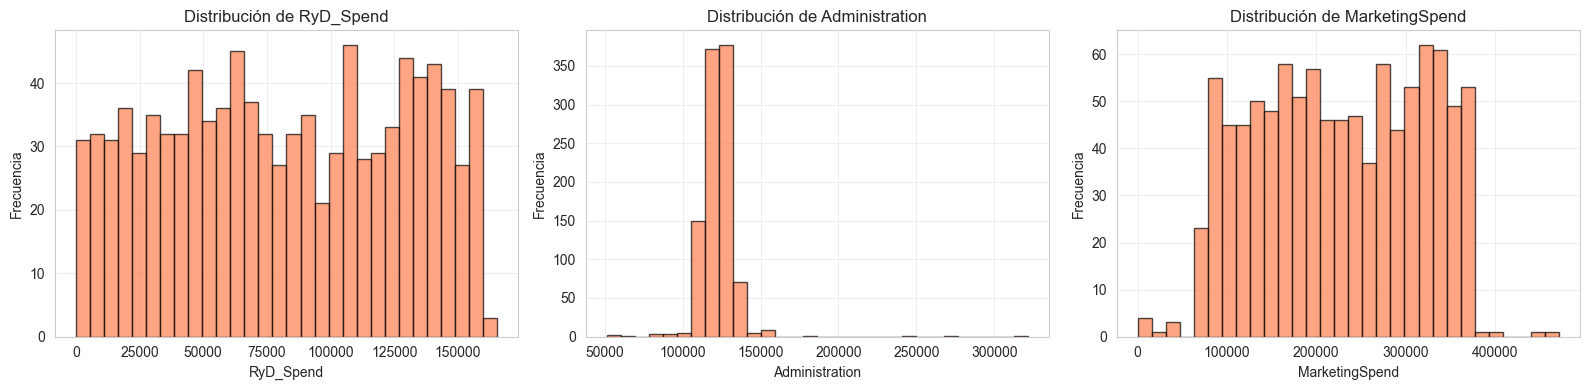

In [192]:
# Distribución de variables numéricas
columnas_numericas = ['RyD_Spend', 'Administration', 'MarketingSpend']

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, col in enumerate(columnas_numericas):
    axes[i].hist(datos_empresas[col], bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

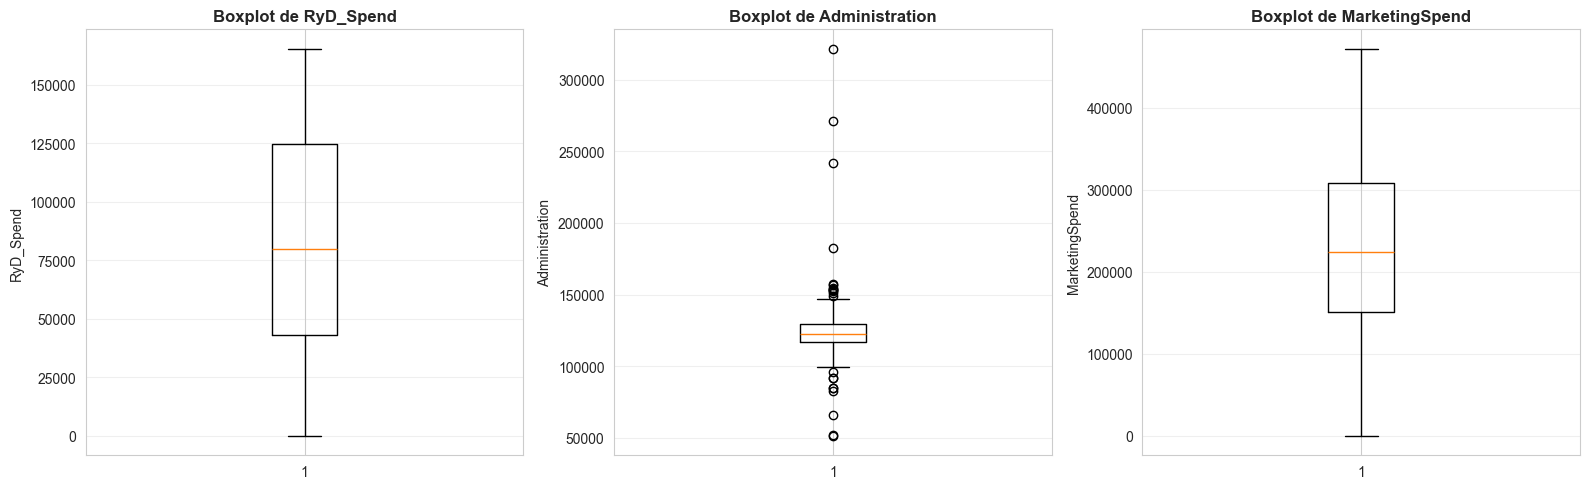

In [193]:
# Boxplots de las 3 variables predictoras numéricas
columnas_numericas = ['RyD_Spend', 'Administration', 'MarketingSpend']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, col in enumerate(columnas_numericas):
    axes[i].boxplot(datos_empresas[col], vert=True)
    axes[i].set_ylabel(col)
    axes[i].set_title(f'Boxplot de {col}', fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

 ------------------------------ JUSTIFICAR NO ELIMINACION DE OUTLIERS

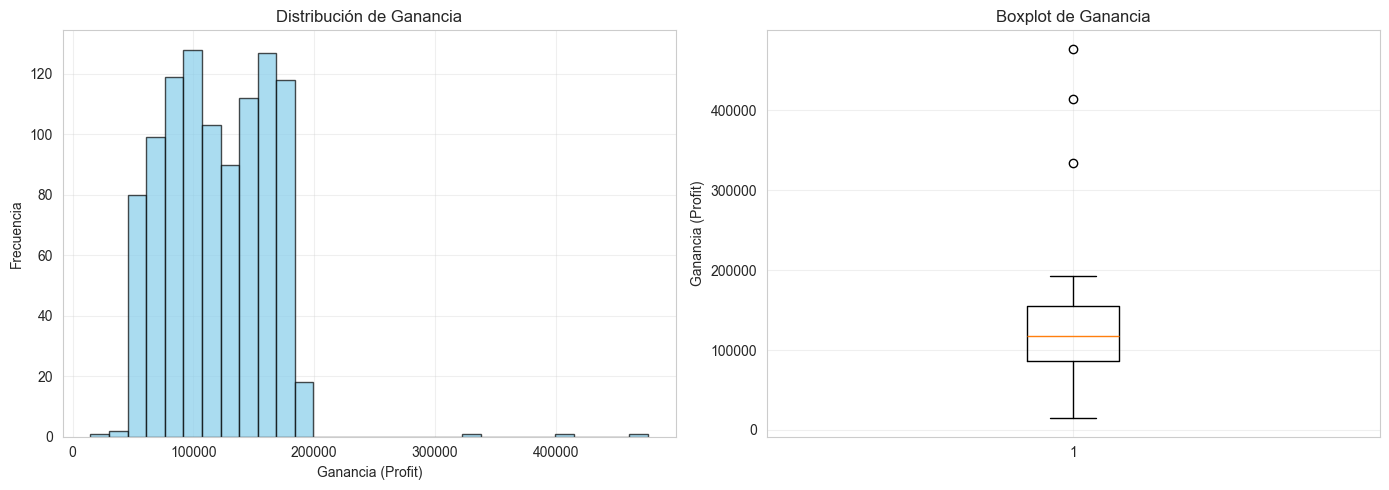

Media de Ganancia: $119,546.16
Mediana de Ganancia: $117,641.47
Desviación estándar: $42,888.63


In [194]:
# Distribución de la variable objetivo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(datos_empresas['Profit'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Ganancia (Profit)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Ganancia')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(datos_empresas['Profit'], vert=True)
axes[1].set_ylabel('Ganancia (Profit)')
axes[1].set_title('Boxplot de Ganancia')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Media de Ganancia: ${datos_empresas['Profit'].mean():,.2f}")
print(f"Mediana de Ganancia: ${datos_empresas['Profit'].median():,.2f}")
print(f"Desviación estándar: ${datos_empresas['Profit'].std():,.2f}")

 ------------------------------ JUSTIFICAR NO ELIMINACION DE OUTLIERS


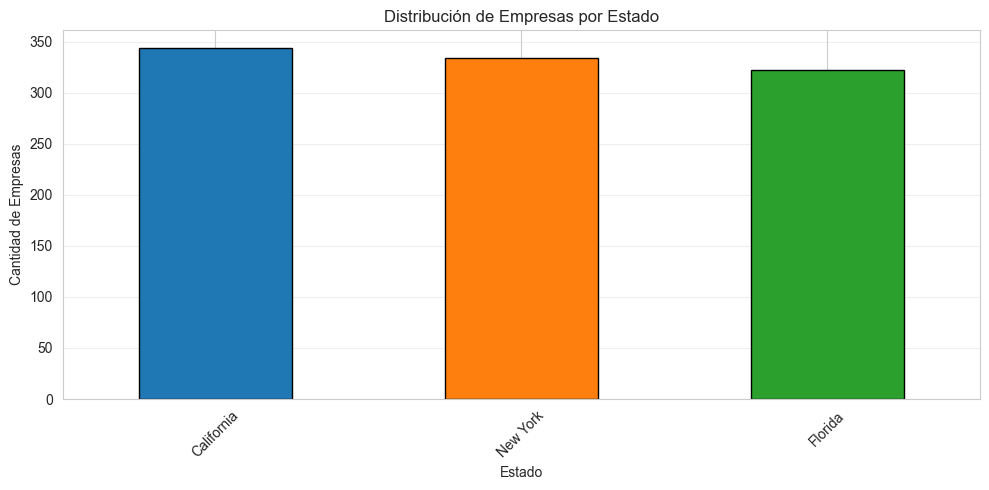


Distribución por Estado:
State
California    344
New York      334
Florida       322
Name: count, dtype: int64

Porcentaje por Estado:
State
California    34.4
New York      33.4
Florida       32.2
Name: count, dtype: float64


In [195]:
# Distribución de la variable categórica State
conteo_estados = datos_empresas['State'].value_counts()

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black')
plt.xlabel('Estado')
plt.ylabel('Cantidad de Empresas')
plt.title('Distribución de Empresas por Estado')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(datos_empresas) * 100).round(2))

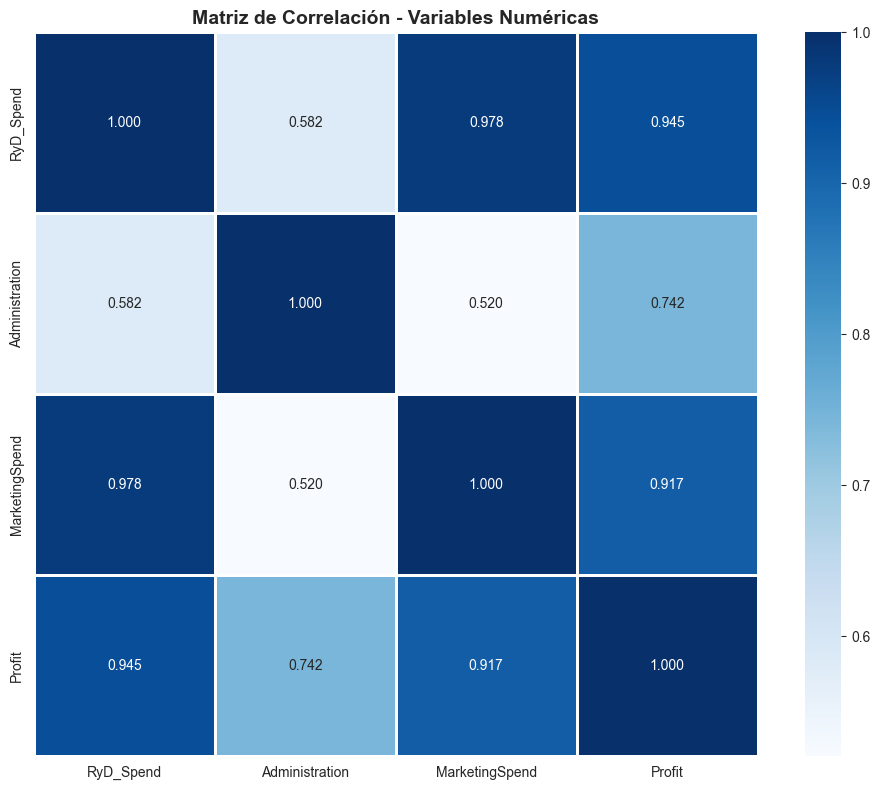


Correlación con Profit:
Profit            1.000000
RyD_Spend         0.945245
MarketingSpend    0.917270
Administration    0.741560
Name: Profit, dtype: float64


In [196]:
# Matriz de correlación
datos_numericos = datos_empresas.select_dtypes(include=[np.number])
matriz_correlacion = datos_numericos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt='.3f', cmap='Blues', square=True, linewidths=1) # No usamos centrado para mejor visualización
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelación con Profit:")
print(matriz_correlacion['Profit'].sort_values(ascending=False))

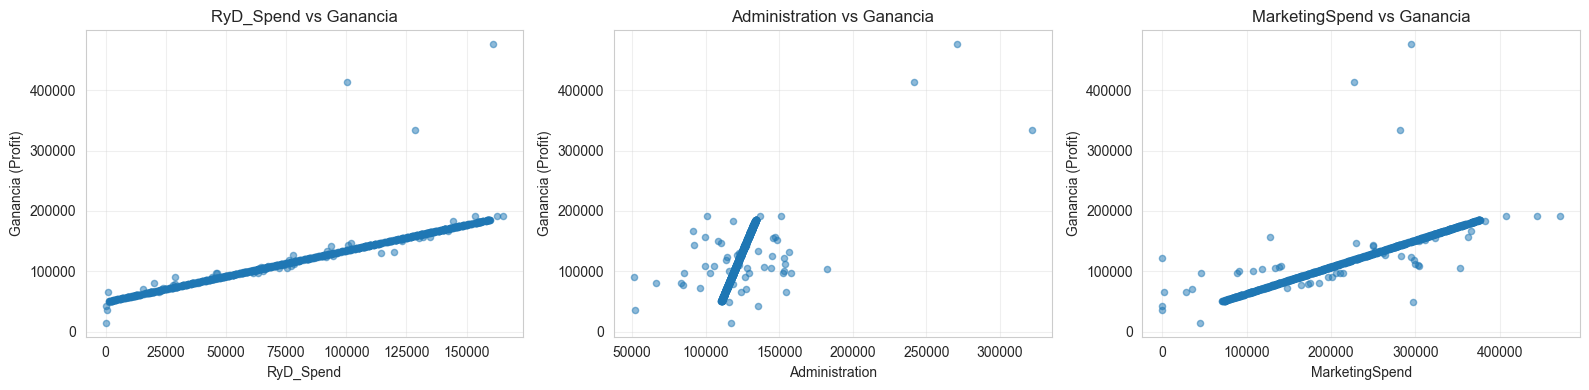

In [197]:
# Scatter plots: relación entre variables predictoras y Profit

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, col in enumerate(columnas_numericas):
    axes[i].scatter(datos_empresas[col], datos_empresas['Profit'], alpha=0.5, s=20)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Ganancia (Profit)')
    axes[i].set_title(f'{col} vs Ganancia')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Preprocesamiento

### Codificacion de variables categóricas 

In [198]:
# Codificación de variables categóricas
 
datos = pd.get_dummies(datos_empresas, columns=['State'], dtype=int)

datos.head()

,RyD_Spend,Administration,MarketingSpend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0,0,1
1,162597.70,151377.59,443898.53,191792.06,1,0,0
2,153441.51,101145.55,407934.54,191050.39,0,1,0
3,144372.41,118671.85,383199.62,182901.99,0,0,1
4,142107.34,91391.77,366168.42,166187.94,0,1,0


### Split 

In [199]:
# Separo variable target (Profit) de variables explicativas 

from re import X


X = datos.drop("Profit", axis=1)
y = datos["Profit"]

In [200]:
# Split train/test 80/20

from random import shuffle


primer_split = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_train_prim, X_test_prim, y_train_prim, y_test_prim = primer_split

print("X_train shape:", X_train_prim.shape)
print("X_test shape:", X_test_prim.shape)
print("y_train shape:", y_train_prim.shape)
print("y_test shape:", y_test_prim.shape)


X_train shape: (800, 6)
X_test shape: (200, 6)
y_train shape: (800,)
y_test shape: (200,)


In [201]:
# Split train/test 70/30

segundo_split = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

X_train_seg, X_test_seg, y_train_seg, y_test_seg = segundo_split

print("X_train shape:", X_train_seg.shape)
print("X_test shape:", X_test_seg.shape)
print("y_train shape:", y_train_seg.shape)
print("y_test shape:", y_test_seg.shape)

X_train shape: (700, 6)
X_test shape: (300, 6)
y_train shape: (700,)
y_test shape: (300,)


## Entrenamiento modelo segun la practica

In [202]:
features = list(X_train_prim.columns)
print(features)

['RyD_Spend', 'Administration', 'MarketingSpend', 'State_California', 'State_Florida', 'State_New York']


In [203]:
# Selección del modelo: hiperparámetros
tree_reg = DecisionTreeRegressor(max_depth=5, criterion='squared_error',
                                 min_samples_leaf=1, min_samples_split=2,
                                 random_state=13)
# Entrenamiento
tree_reg.fit(X_train_prim, y_train_prim)

,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [213]:
# Lista de nombres de las variables
vars_names = list(X_train_prim.columns)
print(vars_names)

['RyD_Spend', 'Administration', 'MarketingSpend', 'State_California', 'State_Florida', 'State_New York']


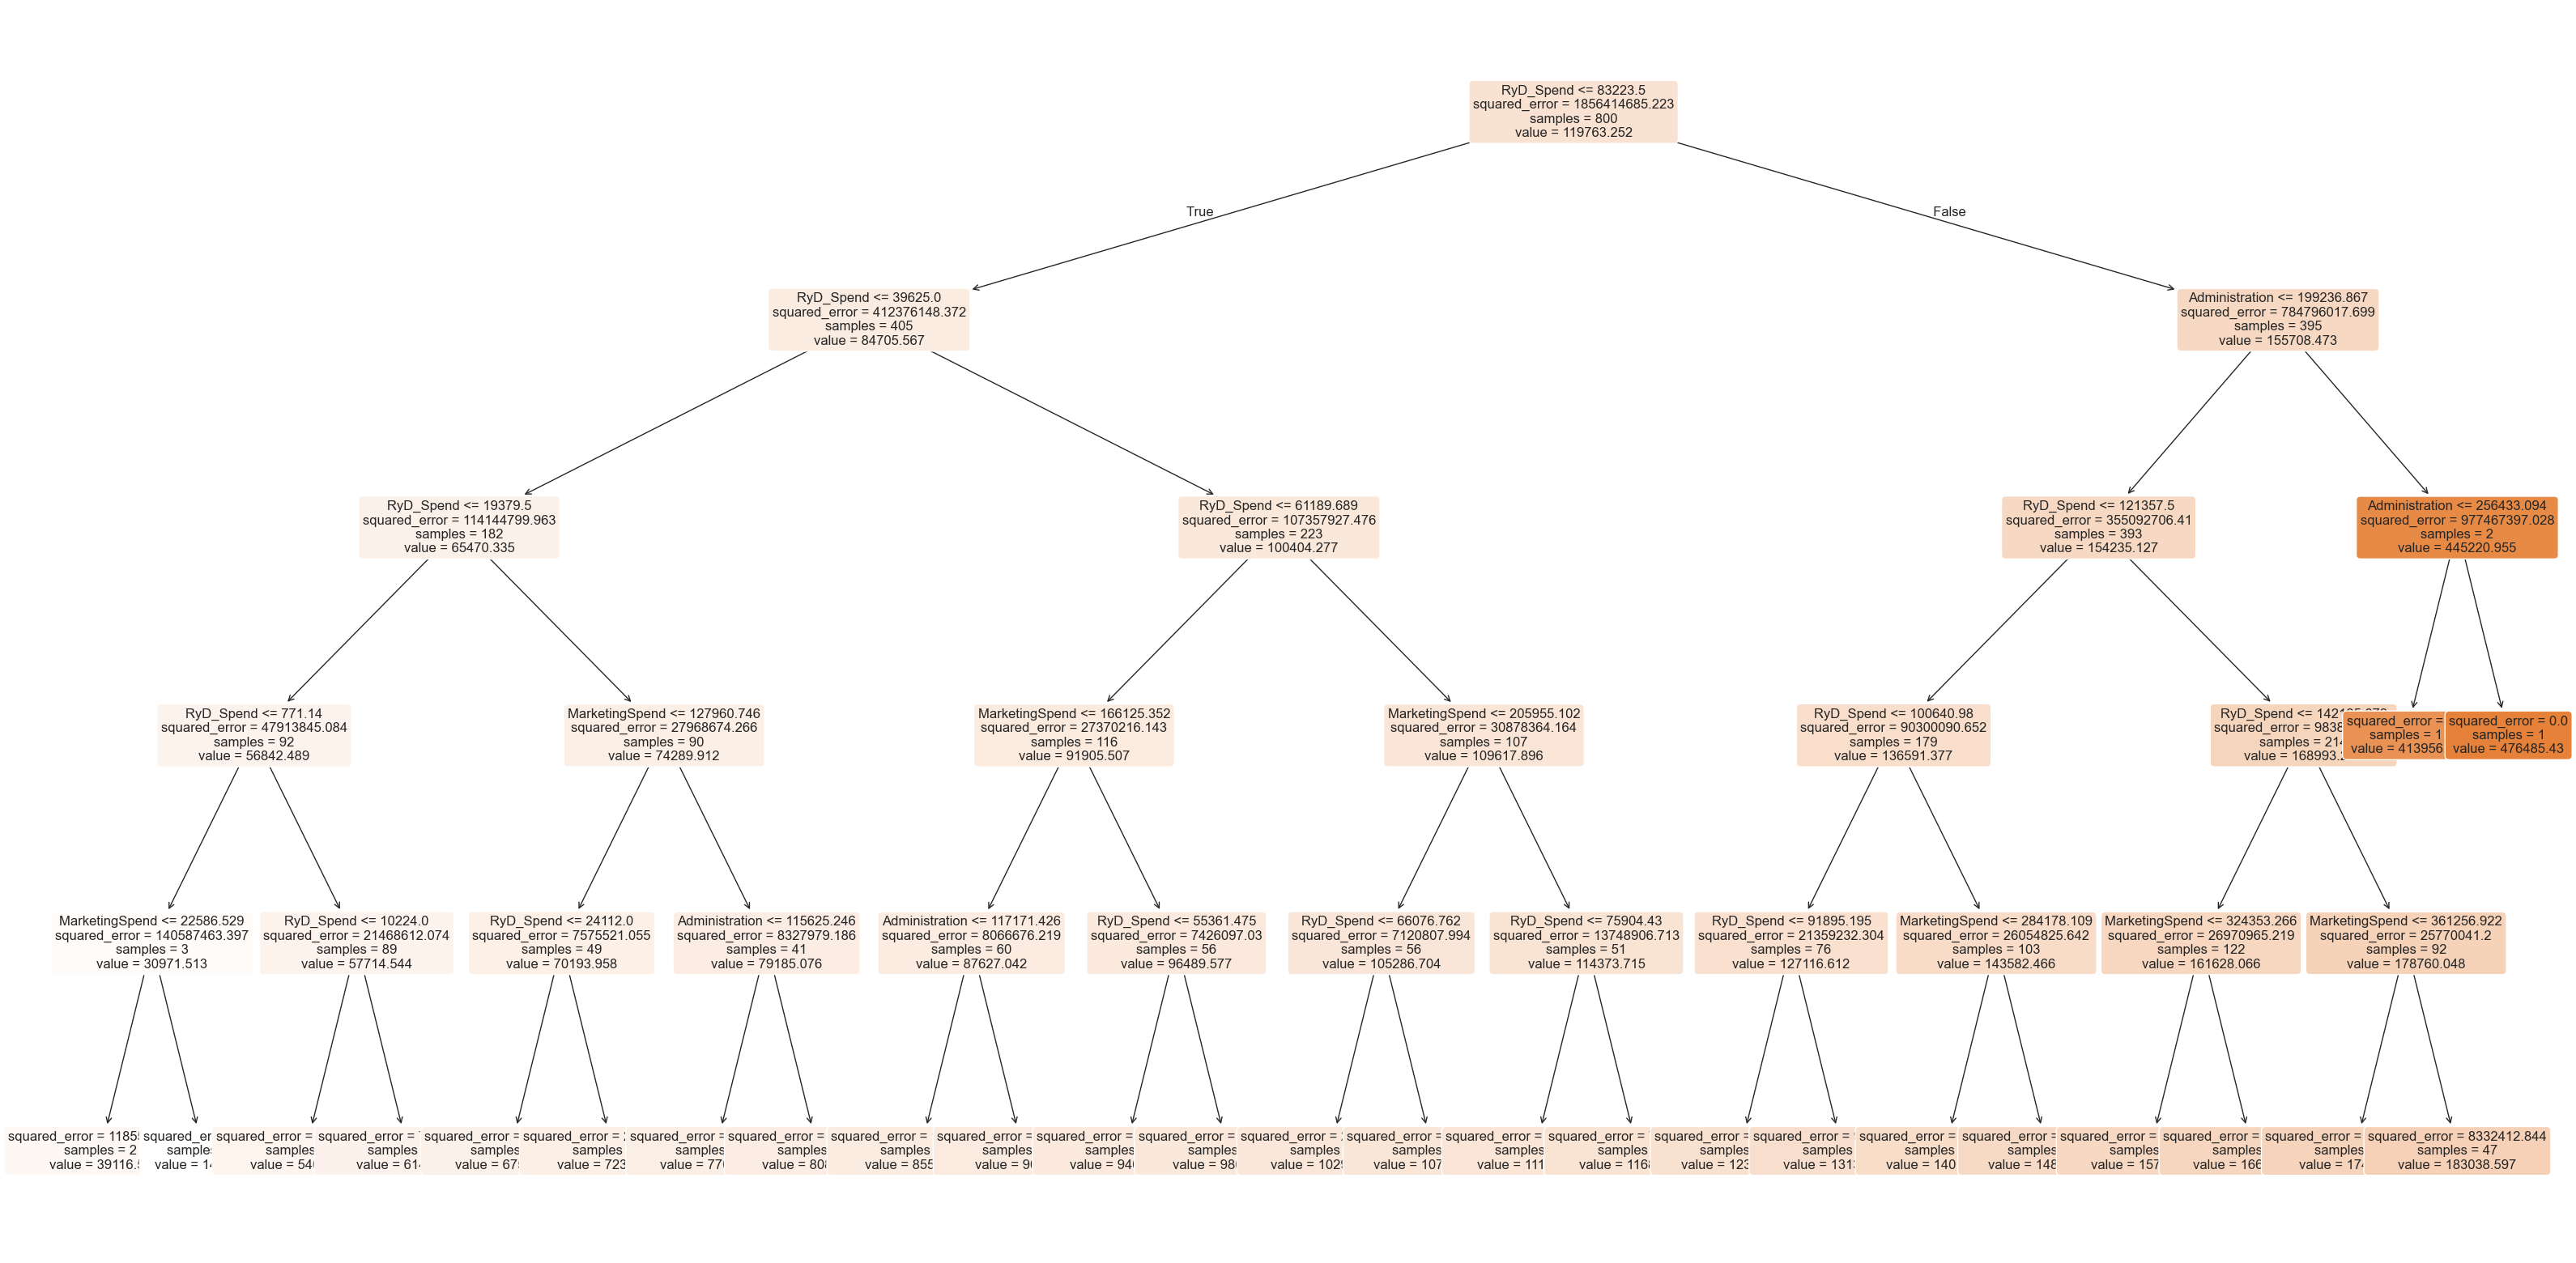

In [223]:
plt.figure(figsize=(40,20))
plot_tree(tree_reg, feature_names=vars_names, fontsize=12, filled=True,
               rounded=True)
plt.show()